# Project Assignment
#### Advanced Probabilistic Machine Learning

### Q.4. A Gibbs Sampler

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import  truncnorm, norm
import matplotlib.pyplot as plt
import time
from tabulate import tabulate

# Matrix A (From Cor.)
A = np.array([[1, -1]])

# p(s) values
mu_s = np.array([[25], [25]])
sigma_s = (25/3) ** 2
cov_s = np.array([[sigma_s, 0], [0, sigma_s]])

# p(t|s)
mu_t_s = 0 # s1 - s2
sigma_t_s = 25/6

# co-variance matrix for p(s|t) (From Q3.1 and Cor. 1)
sigma_inv = np.linalg.inv(cov_s)
sigma_t_inv = 1 / (sigma_t_s ** 2)
sigma_s_t = np.linalg.inv(sigma_inv + np.transpose(A) @ (sigma_t_inv * A))

##### Q4.1. Gibbs Sampling

Let us explain the following code in a sequential way. First, the number of samples is set to $1000$, and $s_1,s_2$, and $t$ are initialized. The first value of $t$ is set to 0 as the result for any match has not yet been observed. After this, to determine $\mu_{s|t}$ the parameters $\sigma_s$ and $\sigma_{t|s}$ and $\sigma_{s|t}$ are used. These will not be updated as are all variances that remain fixed. The only values that will be updated for $\mu_{s|t}$ are $\mu_s$ and $t$. Now, everything is set to sample $s_1$ and $s_2$ based on $\mu_{s|t}$ and update the mean of $p(t|s_1,s_2)$.

Once $s_1$ and $s_2$ have been sampled, $t$ is sampled from a truncated normal distribution obtained in Question 3.2. That is, $t$ is sampled given $s_1$,$s_2$, and $y$, which in this case is $y=1$.

Finally, the loop is reentered, and the posterior distribution $p(s_2,s_2)$ is updated through $\mu_{s|t}$ based on the previous result.

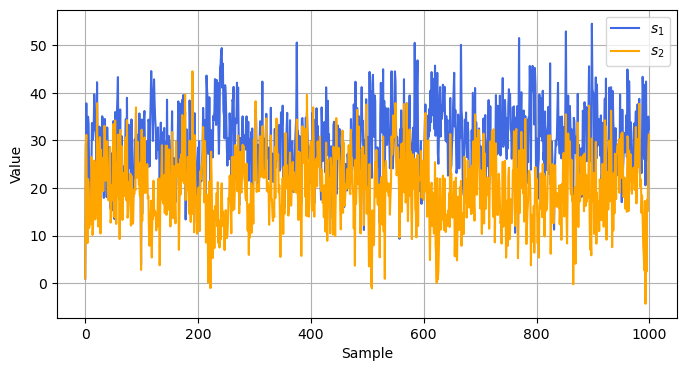

In [8]:
nr_samples = 1000

s1 = np.ones(nr_samples) 
s2 = np.ones(nr_samples) 
t = np.zeros(nr_samples) 

for sample in range(nr_samples-1):
    
    ## From Q3.1 - Determine p(s1, s2 | t) 
    
    # Determine mu for p(s|t)
    mu_s_t = sigma_s_t @ (sigma_inv @ mu_s + np.transpose(A) * (sigma_t_inv * t[sample]))    
    
    # Flatten mu_s_t for 1-dim
    mu_s_t_1d = mu_s_t.flatten()
    
    # Sample new values for s1 and s2 from dist.
    s1[sample+1], s2[sample+1] = np.random.multivariate_normal(mu_s_t_1d, sigma_s_t)
    
    ## From Q3.2 - Determine p(t | s1, s2)
    
    # Mean 
    mu_t = s1[sample+1] - s2[sample+1]

    ## From Q3.3 - Determine p(t)
    
    # As Player 1 wins y=1 -> t>0 -> a=0 and b= inf (=1000 in our case)
    a, b = 0, 1000
    
    # truncnorm needs a, b "in terms of standard deviations from the mean"
    t[sample+1] = truncnorm.rvs((a - mu_t)/sigma_t_s, (b- mu_t)/sigma_t_s, mu_t, sigma_t_s)
    
plt.figure(figsize=(8, 4.0))
plt.plot(s1, label = r'$s_1$', color='royalblue')
plt.plot(s2, label = r'$s_2$', color='orange')
plt.xlabel("Sample")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.savefig('Figure2.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

#### Q4.2. Gibbs Sampling: Recover Trueskill representation

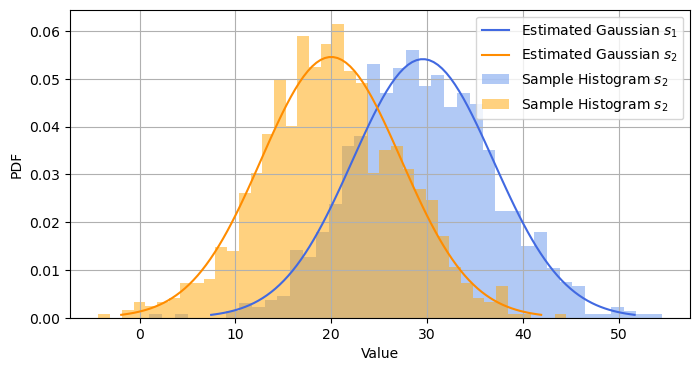

In [10]:
# Sample mean and variance
s1_mean = np.mean(s1)
s1_variance = np.var(s1)
s2_mean = np.mean(s2)
s2_variance = np.var(s2)

# Create an array of x values for plotting
x1 = np.linspace(s1_mean - 3 * np.sqrt(s1_variance), s1_mean + 3 * np.sqrt(s1_variance), 100)
x2 = np.linspace(s2_mean - 3 * np.sqrt(s2_variance), s2_mean + 3 * np.sqrt(s2_variance), 100)

# Calculate the PDF of the estimated Gaussian distribution
pdf = (1 / np.sqrt(2 * np.pi * s1_variance)) * np.exp(-0.5 * ((x1 - s1_mean) ** 2) / s1_variance)
pdf2 = (1 / np.sqrt(2 * np.pi * s2_variance)) * np.exp(-0.5 * ((x2 - s2_mean) ** 2) / s2_variance)

# Plot the estimated Gaussian distribution
plt.figure(figsize=(8, 4.0))
plt.plot(x1, pdf, label="Estimated Gaussian $s_1$",  color='royalblue')
plt.plot(x2, pdf2, label="Estimated Gaussian $s_2$",  color='darkorange')
plt.hist(s1, bins=40,label="Sample Histogram $s_2$", density=True, alpha=0.5, color='cornflowerblue')
plt.hist(s2, bins=40, label="Sample Histogram $s_2$", density=True, alpha=0.5, color='orange')
plt.xlabel("Value")
plt.ylabel("PDF")
plt.grid()
plt.legend()
plt.savefig('Figure3.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

#### Q4.3. Gibbs Sampling using different samples: Recover Trueskill representation

Execution time: 0.0028345584869384766 seconds
Execution time: 0.02208399772644043 seconds
Execution time: 0.10283923149108887 seconds
Execution time: 1.087846279144287 seconds
Execution time: 10.83107852935791 seconds
Execution time: 108.7487530708313 seconds


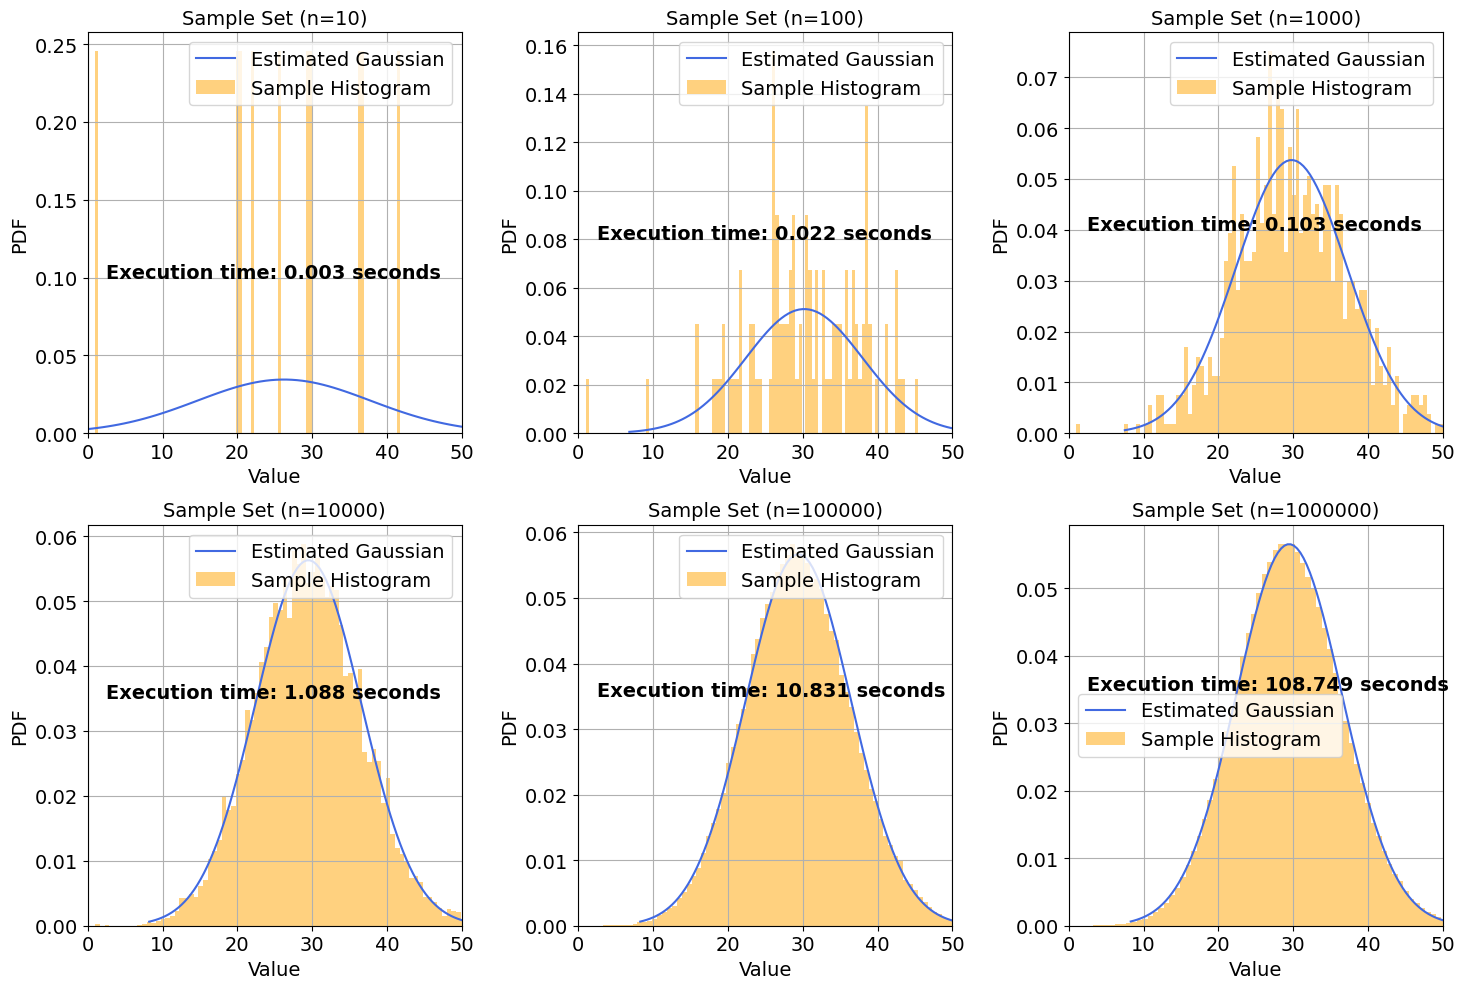

In [24]:
nr_samples_arr = [10, 100, 1000, 10000, 100000, 1000000]
sample_sets = [0, 0, 0, 0, 0, 0]
time_sets=[]

for index, nr_samples in enumerate(nr_samples_arr):
    
    start_time = time.time()
    
    s1 = np.ones(nr_samples) 
    s2 = np.ones(nr_samples) 
    t = np.ones(nr_samples) 
    
    for sample in range(nr_samples-1):
        
        mu_s_t = sigma_s_t @ (sigma_inv @ mu_s + np.transpose(A) * (sigma_t_inv * t[sample]))    

        mu_s_t_1d = mu_s_t.flatten()

        s1[sample+1], s2[sample+1] = np.random.multivariate_normal(mu_s_t_1d, sigma_s_t)

        mu_t = s1[sample+1] - s2[sample+1]

        a, b = 0, 10000

        t[sample+1] = truncnorm.rvs((a - mu_t)/sigma_t_s, (b- mu_t)/sigma_t_s, mu_t, sigma_t_s)

    end_time = time.time()    
    execution_time = end_time - start_time
    time_sets.append(execution_time)
    print(f"Execution time: {execution_time} seconds")
    
    sample_sets[index] = s1.copy()

# Create subplots
num_subplots = len(sample_sets)
num_rows = num_subplots // 3  # Calculate the number of rows
num_cols = 3  # Number of columns

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

vertical_allign = [0.10, 0.08, 0.04, 0.035, 0.035, 0.035]

rounded_time_sets = np.round(time_sets, decimals=3)
times = list(map(str, rounded_time_sets))
times = modified_strings = ["Execution time: " + s + " seconds" for s in times]

for i, samples in enumerate(sample_sets):
    
    # Calculate the sample mean and sample variance
    sample_mean = np.mean(samples)
    sample_variance = np.var(samples, ddof=1)  # Use ddof=1 for unbiased sample variance

    # Parameters for the estimated Gaussian distribution
    estimated_mean = sample_mean
    estimated_variance = sample_variance

    # Create an array of x values for plotting
    x = np.linspace(sample_mean - 3 * np.sqrt(sample_variance), sample_mean + 3 * np.sqrt(sample_variance), 100)

    # Calculate the PDF of the estimated Gaussian distribution
    pdf = (1 / np.sqrt(2 * np.pi * estimated_variance)) * np.exp(-0.5 * ((x - estimated_mean) ** 2) / estimated_variance)

    # Determine the current row and column
    row = i // num_cols
    col = i % num_cols
    
    # Plot the estimated Gaussian distribution on the current subplot
    axs[row, col].plot(x, pdf, label="Estimated Gaussian", color="royalblue")
    axs[row, col].hist(samples, bins = 100, density=True, alpha=0.5, label="Sample Histogram", color="orange")
    text = times[i]
    font = {'weight': 'bold'}
    axs[row, col].text(2.5, vertical_allign[i], text, fontsize=14, color="black", fontdict=font)
    axs[row, col].set_xlabel("Value", fontsize=14)
    axs[row, col].set_xlim(0, 50)
    axs[row, col].set_ylabel("PDF", fontsize=14)
    axs[row, col].tick_params(axis='x', labelsize=14)
    axs[row, col].tick_params(axis='y', labelsize=14)
    axs[row, col].legend(fontsize=14)
    axs[row, col].set_title(f"Sample Set (n={nr_samples_arr[i]})",fontsize=14)
    axs[row, col].grid(True)

plt.tight_layout()  # Ensure proper spacing between subplots
plt.savefig('Figure4.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

#### Q4.4. Prio vs Posteriors

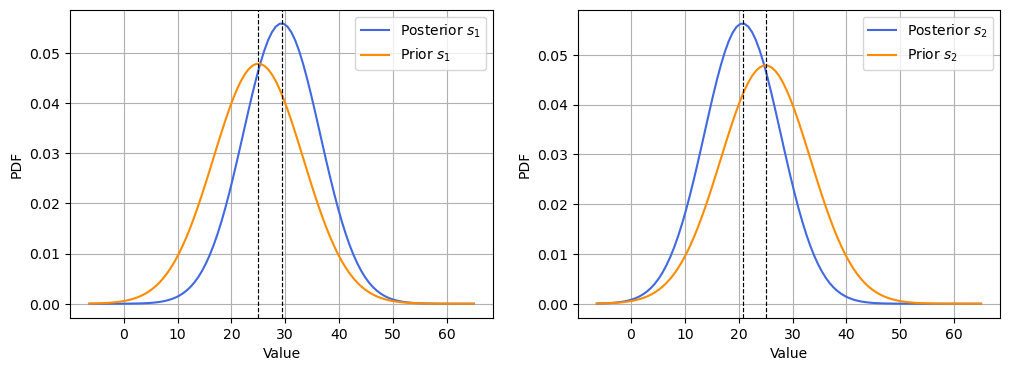

In [25]:
nr_samples = 10000

s1 = np.ones(nr_samples)
s2 = np.ones(nr_samples)
t = np.ones(nr_samples)

for sample in range(nr_samples-1):
    
    mu_s_t = sigma_s_t @ (sigma_inv @ mu_s + np.transpose(A) * (sigma_t_inv * t[sample]))    
    
    mu_s_t_1d = mu_s_t.flatten()
    
    s1[sample+1], s2[sample+1] = np.random.multivariate_normal(mu_s_t_1d, sigma_s_t)
    
    mu_t = s1[sample+1] - s2[sample+1]

    a = 0
    b = nr_samples
    
    t[sample+1] = truncnorm.rvs((a - mu_t)/sigma_t_s, (b- mu_t)/sigma_t_s, mu_t, sigma_t_s)
    
# Sample mean and variance
s1_mean = np.mean(s1)
s1_variance = np.var(s1)
s2_mean = np.mean(s2)
s2_variance = np.var(s2)

# Create an array of x values for plotting
x = np.linspace(s1_mean - 5 * np.sqrt(s1_variance), s1_mean + 5 * np.sqrt(s1_variance), 100)

# Calculate the PDF of the estimated Gaussian distribution
pdf_prior = (1 / np.sqrt(2 * np.pi * sigma_s)) * np.exp(-0.5 * ((x - mu_s[1][0]) ** 2) / sigma_s)

pdfs1 = (1 / np.sqrt(2 * np.pi * s1_variance)) * np.exp(-0.5 * ((x - s1_mean) ** 2) / s1_variance)
pdfs2 = (1 / np.sqrt(2 * np.pi * s2_variance)) * np.exp(-0.5 * ((x - s2_mean) ** 2) / s2_variance)

# Plot the estimated Gaussian distribution
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(x, pdfs1, label="Posterior $s_1$", color='royalblue')
axes[0].plot(x, pdf_prior, label="Prior $s_1$", color='darkorange')
axes[0].axvline(x = s1_mean  , color='black', linestyle='--', linewidth=0.85)
axes[0].axvline(x = mu_s[1][0], color='black', linestyle='--', linewidth=0.85)
axes[0].set_xlabel("Value")
axes[0].set_ylabel("PDF")
axes[0].grid()
axes[0].legend()

axes[1].plot(x, pdfs2, label="Posterior $s_2$", color='royalblue')
axes[1].plot(x, pdf_prior, label="Prior $s_2$", color='darkorange')
axes[1].axvline(x = s2_mean  , color='black', linestyle='--', linewidth=0.85)
axes[1].axvline(x = mu_s[1][0], color='black', linestyle='--', linewidth=0.85)
axes[1].set_xlabel("Value")
axes[1].set_ylabel("PDF")
axes[1].grid()
axes[1].legend()

plt.savefig('Figure5.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

### Q5. Assumed Density Filtering 

#### Pre-processing

In [26]:
data = pd.read_csv('SerieA.csv')

# Drop Unessesary columns
data = data.drop(['yyyy-mm-dd', 'HH:MM'], axis=1)

# Remove tied games
data = data[data['score1'] != data['score2']]

# Create result column
data['result'] = data['score1'] - data['score2']

# get result of the game (1 or -1)
data['result'] = data['result'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Drop score columns
data = data.drop(['score1', 'score2'], axis=1)

data.head()

team1     team2  result
0    Chievo  Juventus      -1
1     Lazio    Napoli      -1
2    Torino      Roma      -1
3  Sassuolo     Inter       1
5    Empoli  Cagliari       1

#### Gibbs function

In [2]:
"""
This function will determine new mean and standard deviation for s1 and s2 using gibbs sampling
"""
def gibbs_sampling(mu_1, sigma_1, mu_2, sigma_2, nr_samples):
    
    # Matrix A (From Cor.)
    A = np.array([[1, -1]])

    # p(s) values
    mu_s = np.array([[mu_1], [mu_2]])
    cov_s = np.array([[sigma_1**2, 0], [0, sigma_2**2]])

    # p(t|s)
    sigma_t_s = 25/6

    # co-variance matrix for p(s|t) (From Q3.1 and Cor. 1)
    sigma_inv = np.linalg.inv(cov_s)
    sigma_t_inv = 1 / (sigma_t_s ** 2)
    sigma_s_t = np.linalg.inv(sigma_inv + np.transpose(A) * (sigma_t_inv) @ A)
    
    ## Gibbs Sampling
    
    s1 = np.ones(nr_samples)
    s2 = np.ones(nr_samples)
    t = np.ones(nr_samples)

    for sample in range(nr_samples-1):
        
        mu_s_t = sigma_s_t @ (sigma_inv @ mu_s + np.transpose(A) * (sigma_t_inv * t[sample]))    

        mu_s_t_1d = mu_s_t.flatten()

        s1[sample+1], s2[sample+1] = np.random.multivariate_normal(mu_s_t_1d, sigma_s_t)

        mu_t = s1[sample+1] - s2[sample+1]

        a = 0
        b = nr_samples

        t[sample+1] = truncnorm.rvs((a - mu_t)/sigma_t_s, (b- mu_t)/sigma_t_s, mu_t, sigma_t_s)
             
    ## Determine new mean and std
    s1_mean, s1_sigma = np.mean(s1), np.std(s1)
    s2_mean, s2_sigma = np.mean(s2), np.std(s2)

    return s1_mean, s1_sigma, s2_mean , s2_sigma

#### Skill Dictionary

In [28]:
"""
This Dictionary is used to stored up-to-date skills for all the teams

"""

# Get unique team names
unique_teams = set(data['team1'].unique()) | set(data['team2'].unique())

# Create skill dictionary
skill_dictionary = {team: {'mean': 25, 'sigma': 25/3} for team in unique_teams}

print(skill_dictionary)

{'Lazio': {'mean': 25, 'sigma': 8.333333333333334}, 'Atalanta': {'mean': 25, 'sigma': 8.333333333333334}, 'Genoa': {'mean': 25, 'sigma': 8.333333333333334}, 'Parma': {'mean': 25, 'sigma': 8.333333333333334}, 'Udinese': {'mean': 25, 'sigma': 8.333333333333334}, 'Roma': {'mean': 25, 'sigma': 8.333333333333334}, 'Sassuolo': {'mean': 25, 'sigma': 8.333333333333334}, 'Sampdoria': {'mean': 25, 'sigma': 8.333333333333334}, 'Frosinone': {'mean': 25, 'sigma': 8.333333333333334}, 'Empoli': {'mean': 25, 'sigma': 8.333333333333334}, 'Napoli': {'mean': 25, 'sigma': 8.333333333333334}, 'Torino': {'mean': 25, 'sigma': 8.333333333333334}, 'Inter': {'mean': 25, 'sigma': 8.333333333333334}, 'Bologna': {'mean': 25, 'sigma': 8.333333333333334}, 'Cagliari': {'mean': 25, 'sigma': 8.333333333333334}, 'Fiorentina': {'mean': 25, 'sigma': 8.333333333333334}, 'Chievo': {'mean': 25, 'sigma': 8.333333333333334}, 'Milan': {'mean': 25, 'sigma': 8.333333333333334}, 'Juventus': {'mean': 25, 'sigma': 8.333333333333334}

#### Implementation

In [29]:
# Loops through all the games in the pre-processed dataset
for index, row in data.iterrows():
    
    team1 = row['team1'] # Name of team 1
    team2 = row['team2'] # Name of team 2
    result = row['result'] # y-value (Who won the game)
    
    s1_mean, s1_sigma = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
    s2_mean, s2_sigma = skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma']
    
    # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if the lost
    if (result > 0):
        s1_mean, s1_sigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, 10000)
    else:
        s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, 10000) 
     
    # Update new values
    skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma
    skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma
    
print(skill_dictionary)

{'Lazio': {'mean': 25.459815506459528, 'sigma': 1.4981170238281851}, 'Atalanta': {'mean': 28.46874278621581, 'sigma': 1.53593248138676}, 'Genoa': {'mean': 23.56266773135392, 'sigma': 1.5705115783981236}, 'Parma': {'mean': 22.81937071670057, 'sigma': 1.468892015865093}, 'Udinese': {'mean': 24.229752863596264, 'sigma': 1.5618536120021251}, 'Roma': {'mean': 27.511980080108543, 'sigma': 1.5648355189669676}, 'Sassuolo': {'mean': 22.448778845549604, 'sigma': 1.6887137301037707}, 'Sampdoria': {'mean': 24.538545342127296, 'sigma': 1.4515806496913786}, 'Frosinone': {'mean': 20.219128673994927, 'sigma': 1.6306578760319679}, 'Empoli': {'mean': 24.02355823797535, 'sigma': 1.4757882123212165}, 'Napoli': {'mean': 28.90469788839397, 'sigma': 1.7527361005807907}, 'Torino': {'mean': 27.791337532622926, 'sigma': 1.6170059097025307}, 'Inter': {'mean': 27.823629384143494, 'sigma': 1.5923422812641788}, 'Bologna': {'mean': 24.95196360083092, 'sigma': 1.5172699612604408}, 'Cagliari': {'mean': 23.201380654537

#### Ranking the teams

In [30]:
# Sort teams by rank (i.e their mean)
sorted_teams = sorted(skill_dictionary.items(), key=lambda x: x[1]['mean'], reverse=True)

# Create a list of lists for tabulate with formatted values
table_data = [
    [rank, team, f'{data["mean"]:.3f}', f'{data["sigma"]:.3f}']
    for rank, (team, data) in enumerate(sorted_teams, start=1)
]

# Define the table headers
headers = ["Rank", "Team", "Mean", "Standard Deviation"]

# Use tabulate to print the table
print(tabulate(table_data, headers, tablefmt="pretty"))

+------+------------+--------+--------------------+
| Rank |    Team    |  Mean  | Standard Deviation |
+------+------------+--------+--------------------+
|  1   |   Napoli   | 28.905 |       1.753        |
|  2   |   Milan    | 28.559 |       1.690        |
|  3   |  Atalanta  | 28.469 |       1.536        |
|  4   |  Juventus  | 28.025 |       1.947        |
|  5   |   Inter    | 27.824 |       1.592        |
|  6   |   Torino   | 27.791 |       1.617        |
|  7   |    Roma    | 27.512 |       1.565        |
|  8   |   Lazio    | 25.460 |       1.498        |
|  9   |  Bologna   | 24.952 |       1.517        |
|  10  | Sampdoria  | 24.539 |       1.452        |
|  11  |    Spal    | 24.277 |       1.466        |
|  12  |  Udinese   | 24.230 |       1.562        |
|  13  |   Empoli   | 24.024 |       1.476        |
|  14  |   Genoa    | 23.563 |       1.571        |
|  15  |  Cagliari  | 23.201 |       1.510        |
|  16  |   Parma    | 22.819 |       1.469        |
|  17  |  Sa

#### Once again, but the games at random!

In [31]:
## Preprocessing
data = pd.read_csv('SerieA.csv')
data = data.drop(['yyyy-mm-dd', 'HH:MM'], axis=1)
data = data[data['score1'] != data['score2']]
data['result'] = data['score1'] - data['score2']
data['result'] = data['result'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
data = data.drop(['score1', 'score2'], axis=1)

# Randomize
data = data.sample(frac=1.0, random_state=42)
# Reset the index
data.reset_index(drop=True, inplace=True)

## Skill Dictionary
# Get unique team names
unique_teams = set(data['team1'].unique()) | set(data['team2'].unique())

# Create skill dictionary
skill_dictionary = {team: {'mean': 25, 'sigma': 25/3} for team in unique_teams}

## Implementation
# Loops through all the games in the pre-processed dataset
for index, row in data.iterrows():
    
    team1 = row['team1'] # Name of team 1
    team2 = row['team2'] # Name of team 2
    result = row['result'] # y-value (Who won the game)
    
    s1_mean, s1_sigma = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
    s2_mean, s2_sigma = skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma']
    
    # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if the lost
    if (result > 0):
        s1_mean, s1_sigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, 10000)
    else:
        s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, 10000) 
    
    # Update new values
    skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma
    skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma
    
## Print rankings
# Sort tteams by rank (i.e their mean)
sorted_teams = sorted(skill_dictionary.items(), key=lambda x: x[1]['mean'], reverse=True)

# Create a list of lists for tabulate with formatted values
table_data = [
    [rank, team, f'{data["mean"]:.3f}', f'{data["sigma"]:.3f}']
    for rank, (team, data) in enumerate(sorted_teams, start=1)
]

# Define the table headers
headers = ["Rank", "Team", "Mean", "Standard Deviation"]

# Use tabulate to print the table
print(tabulate(table_data, headers, tablefmt="pretty"))

+------+------------+--------+--------------------+
| Rank |    Team    |  Mean  | Standard Deviation |
+------+------------+--------+--------------------+
|  1   |   Napoli   | 31.382 |       1.713        |
|  2   |  Juventus  | 30.034 |       1.837        |
|  3   |   Milan    | 28.865 |       1.641        |
|  4   |   Torino   | 28.563 |       1.610        |
|  5   |    Roma    | 28.287 |       1.579        |
|  6   |  Atalanta  | 28.201 |       1.461        |
|  7   |   Inter    | 27.786 |       1.586        |
|  8   |   Lazio    | 26.255 |       1.515        |
|  9   | Sampdoria  | 25.667 |       1.431        |
|  10  |  Bologna   | 25.544 |       1.486        |
|  11  |  Sassuolo  | 24.002 |       1.632        |
|  12  |  Udinese   | 23.957 |       1.441        |
|  13  |  Cagliari  | 23.853 |       1.468        |
|  14  |    Spal    | 23.610 |       1.412        |
|  15  |   Genoa    | 23.534 |       1.601        |
|  16  |   Empoli   | 23.418 |       1.427        |
|  17  |   P

### Q6. Using the model for predictions 

#### Pre processing

In [15]:
data = pd.read_csv('SerieA.csv')
data = data.drop(['yyyy-mm-dd', 'HH:MM'], axis=1)
data = data[data['score1'] != data['score2']]
data['result'] = data['score1'] - data['score2']
data['result'] = data['result'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
data = data.drop(['score1', 'score2'], axis=1)

#### Creating Skill Dictionary

In [16]:
# Get unique team names
unique_teams = set(data['team1'].unique()) | set(data['team2'].unique())

# Create skill dictionary
skill_dictionary = {team: {'mean': 25, 'sigma': 25/3} for team in unique_teams}

#### Function used for prediction

In [17]:
# Prediction using our Bayesian network
def prediction(mu_1, std_1, mu_2, std_2):

    t = mu_1 - mu_2
        
    y = np.sign(t)
    
    return y

#### Implementing one-step-ahead predictions 

In [18]:
# Loops through all the games in the pre-processed dataset
correct_prediction = 0
for index, row in data.iterrows():
    
    team1 = row['team1'] # Name of team 1
    team2 = row['team2'] # Name of team 2
    result = row['result'] # y-value (Who won the game)
    
    s1_mean, s1_sigma = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
    s2_mean, s2_sigma = skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma']
    
    result_pred = prediction(s1_mean, s1_sigma, s2_mean, s2_sigma)
    
    # Increment if prediction is correct
    if (result_pred == result):
        correct_prediction += 1
        
    # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if the lost
    if (result > 0):
        s1_mean, s1_sigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, 10000)
    else:
        s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, 10000) 
    
    # Update new values
    skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma
    skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma

print("Number of games with no draws ", data.shape[0])
print("Correct predictions: ", correct_prediction)
print("Prediction rate r =", correct_prediction/data.shape[0])

Number of games with no draws  272
Correct predictions:  174
Prediction rate r = 0.6397058823529411


### Q8. A message-passing algorithm

In [44]:
def mutiplyGauss (m1 , s1 , m2 , s2):
    # computes the Gaussian distribution N(m,s) being propotional to N(m1,s1)*N(m2,s2)

    # Input:
    # m1, s1: mean and variance of first Gaussian
    # m2, s2: mean and variance of second Gaussian

    # Output:
    # m, s: mean and variance of the product Gaussian

    s = 1/(1/ s1 +1/ s2)
    m = (m1/s1+m2/s2)*s
    return m, s

def divideGauss (m1 , s1 , m2 , s2):
    # computes the Gaussian distribution N(m,s) being propotional to N(m1,s1)/N(m2,s2)
    
    # Input:
    # m1, s1: mean and variance of the numerator Gaussian
    # m2, s2: mean and variance of the denominator Gaussian
    
    # Output:
    # m, s: mean and variance of the quotient Gaussian

    m, s = mutiplyGauss (m1 , s1 , m2 , -s2)
    return m, s

def truncGaussMM (a, b, m0 , s0):
    # computes the mean and variance of a truncated Gaussian distribution

    # Input:
    # a, b: The interval [a, b] on which the Gaussian is being truncated
    # m0,s0: mean and variance of the Gaussian which is to be truncated

    # Output:
    # m, s: mean and variance of the truncated Gaussian

    # scale interval with mean and variance
    a_scaled , b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = truncnorm .mean(a_scaled , b_scaled , loc=m0 , scale=np.sqrt(s0))
    s = truncnorm .var(a_scaled , b_scaled , loc=m0 , scale=np.sqrt(s0))
    return m, s

In [45]:
# Define the hyperparameters for the problem
mu_1 = 25
mu_2 = 25
sigma_1 = (25/3)**2
sigma_2 = (25/3)**2
sigma_t = (25/6)**2
y0 = 1

# MESSAGES TO COMPUTE THE MARGINAL p(t)

# Message mu1 from prior to node s_1
mu1_m = mu_1 # mean of message
mu1_s = sigma_1 # variance of message

# Message mu3 from prior to node s_2
mu3_m = mu_2 # mean of message
mu3_s = sigma_2 # variance of message

# Message mu2 from node s_1 to factor f_{s_1, s_2, t}
mu2_m = mu1_m
mu2_s = mu1_s

# Message mu4 from node s_2 to factor f_{s_1, s_2, t}
mu4_m = mu3_m
mu4_s = mu3_s

# Message mu5 from factor factor f_{s_1, s_2, t} to node t
mu5_m = mu2_m - mu4_m
mu5_s = mu2_s + mu4_s + sigma_t

# Do moment matching of the marginal of t which is the result of \mu_7x\mu_5
if y0 == 1:
    a, b = 0, np.Inf
else:
    a, b = np.NINF , 0

pt_m , pt_s = truncGaussMM (a, b, mu5_m , mu5_s)

# BACKPROPAGATING THE MESSAGE TO COMPUTE THE POSTERIOR DISTRIBUTION 
# FOR EACH OF THE TWO SKILLS GIVEN THE RESULT OF ONE GAME

# Compute the message from t to f_{s_1, s_2, t}
mu8_m , mu8_s = divideGauss (pt_m , pt_s , mu5_m , mu5_s) # Won't use it

# Compute the message from  f_{s_1, s_2, t} to s_1
mu9_m = pt_m + mu_2
mu9_s = pt_s + sigma_2 + sigma_t

# Compute the message from  f_{s_1, s_2, t} to s_2
mu10_m = mu_1 - pt_m
mu10_s = sigma_1 + pt_s + sigma_t

# Compute the marginal of s_1
ps_1_m , ps_1_s = mutiplyGauss (mu2_m , mu2_s , mu9_m , mu9_s)

# Compute the marginal of s_2
ps_2_m , ps_2_s = mutiplyGauss (mu4_m , mu4_s , mu10_m , mu10_s)

print(ps_1_m, ps_1_s)
print(ps_2_m, ps_2_s)

28.2512514958193 46.80644742400835
21.748748504180696 46.80644742400835


#### Plotting the approximated skill Gaussians vs Gibbs sampling histogram

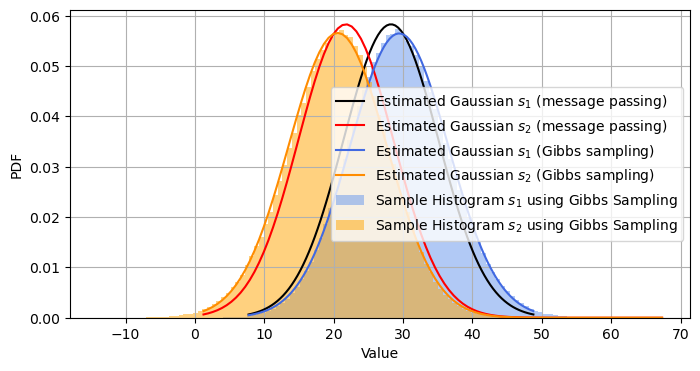

In [62]:
# Matrix A (From Cor.)
A = np.array([[1, -1]])

# p(s) values
mu_s = np.array([[25], [25]])
sigma_s = (25/3) ** 2
cov_s = np.array([[sigma_s, 0], [0, sigma_s]])

# p(t|s)
mu_t_s = 0 # s1 - s2
sigma_t_s = 25/6

# co-variance matrix for p(s|t) (From Q3.1 and Cor. 1)
sigma_inv = np.linalg.inv(cov_s)
sigma_t_inv = 1 / (sigma_t_s ** 2)
sigma_s_t = np.linalg.inv(sigma_inv + np.transpose(A) @ (sigma_t_inv * A))

# Gibbs Sampling

nr_samples = 1000000

s1 = np.ones(nr_samples) 
s2 = np.ones(nr_samples) 
t = np.zeros(nr_samples) 

for sample in range(nr_samples-1):
    
    mu_s_t = sigma_s_t @ (sigma_inv @ mu_s + np.transpose(A) * (sigma_t_inv * t[sample]))    
    
    mu_s_t_1d = mu_s_t.flatten()
    
    s1[sample+1], s2[sample+1] = np.random.multivariate_normal(mu_s_t_1d, sigma_s_t)
    
    mu_t = s1[sample+1] - s2[sample+1]

    a = 0
    b= nr_samples
    
    t[sample+1] = truncnorm.rvs((a - mu_t)/sigma_t_s, (b- mu_t)/sigma_t_s, mu_t, sigma_t_s)
    
s1_mean = np.mean(s1)
s1_variance = np.var(s1)
s2_mean = np.mean(s2)
s2_variance = np.var(s2)    
  
# Create an array of x values for plotting
x1 = np.linspace(ps_1_m - 3 * np.sqrt(ps_1_s), ps_1_m + 3 * np.sqrt(ps_1_s), 100)
x2 = np.linspace(ps_2_m - 3 * np.sqrt(ps_2_s), ps_2_s + 3 * np.sqrt(ps_2_s), 100)

# Calculate the PDF of the estimated Gaussian distribution using moment matching and message passing
pdf = (1 / np.sqrt(2 * np.pi * ps_1_s)) * np.exp(-0.5 * ((x1 - ps_1_m) ** 2) / ps_1_s)
pdf2 = (1 / np.sqrt(2 * np.pi * ps_2_s)) * np.exp(-0.5 * ((x2 - ps_2_m) ** 2) / ps_2_s)

# Calculate the PDF of the estimated Gaussian distribution using Gibbs sampling
pdf_gibbs = (1 / np.sqrt(2 * np.pi * s1_variance)) * np.exp(-0.5 * ((x1 - s1_mean) ** 2) / s1_variance)
pdf2_gibbs = (1 / np.sqrt(2 * np.pi * s2_variance)) * np.exp(-0.5 * ((x2 - s2_mean) ** 2) / s2_variance)

# Plot the estimated Gaussian distribution
plt.figure(figsize=(8, 4.0))
plt.plot(x1, pdf, label="Estimated Gaussian $s_1$ (message passing)",  color='black')
plt.plot(x2, pdf2, label="Estimated Gaussian $s_2$ (message passing)",  color='red')
plt.plot(x1, pdf_gibbs, label="Estimated Gaussian $s_1$ (Gibbs sampling)", color='royalblue')
plt.plot(x2, pdf2_gibbs, label="Estimated Gaussian $s_2$ (Gibbs sampling)", color='darkorange')
plt.hist(s1, bins=100,label="Sample Histogram $s_1$ using Gibbs Sampling", density=True, alpha=0.5, color='cornflowerblue')
plt.hist(s2, bins=100, label="Sample Histogram $s_2$ using Gibbs Sampling", density=True, alpha=0.5, color='orange')
plt.xlabel("Value")
plt.ylabel("PDF")
plt.grid()
plt.legend()
plt.savefig('Figure6.png', format='png', dpi=400, bbox_inches='tight')
plt.show()

### Q9. Your Own Data

#### Pre-processing

In [21]:
data = pd.read_csv('League_of_Legends_dataset.csv', header=0)
data.to_csv('encoded_data.csv', encoding='utf-8', index=False)
# Remove zero-width space characters from the 'team1' column
data['team1'] = data['team1'].str.replace('\u2060\u2060', '')
# Remove zero-width space characters from the 'team2' column
data['team2'] = data['team2'].str.replace('\u2060\u2060', '')

total_games = data.shape[0]

# Create result column
data['result'] = data['score1'] - data['score2']

# get result of the game (1 or -1)
data['result'] = data['result'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Drop score columns
data = data.drop(['score1', 'score2'], axis=1)

data

team1                team2  result
0            Dplus Kia                  DRX       1
1                   T1               Gen. G       1
2     Kwangdong Freecs  Hanwha Life Esports      -1
3    Nongshim RedForce                BRION      -1
4                   T1           KT Rolster       1
..                 ...                  ...     ...
191             Gen. G  Hanwha Life Esports       1
192                 T1               Gen. G      -1
193         KT Rolster  Hanwha Life Esports       1
194                 T1           KT Rolster       1
195             Gen. G                   T1       1

[196 rows x 3 columns]

#### Skill dictionary

In [64]:
"""
This Dictionary is used to stored up-to-date skills for all the teams

"""

# Get unique team names
# The | operator is used for set union, which combines the unique values from both sets into one set
unique_teams = set(data['team1'].unique()) | set(data['team2'].unique())

# Create skill dictionary
skill_dictionary = {team: {'mean': 25, 'sigma': 25/3} for team in unique_teams}

print(skill_dictionary)

### Implementation

# Loops through all the games in the pre-processed dataset
for index, row in data.iterrows():
    
    team1 = row['team1'] # Name of team 1
    team2 = row['team2'] # Name of team 2
    result = row['result'] # y-value (Who won the game)
    
    s1_mean, s1_sigma = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
    s2_mean, s2_sigma = skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma']
    
    # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if team1 loses
    # We use 10000 samples as we concluded to eb the most optimal choice (motivated on the report)
    if (result > 0):
        s1_mean, s1_sigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, 10000)
    else:
        s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, 10000) 
        
    # Update new values
    skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma
    skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma
    
print(skill_dictionary)

{'Nongshim RedForce': {'mean': 25, 'sigma': 8.333333333333334}, 'Gen. G': {'mean': 25, 'sigma': 8.333333333333334}, 'Dplus Kia': {'mean': 25, 'sigma': 8.333333333333334}, 'DRX': {'mean': 25, 'sigma': 8.333333333333334}, 'Hanwha Life Esports': {'mean': 25, 'sigma': 8.333333333333334}, 'T1': {'mean': 25, 'sigma': 8.333333333333334}, 'KT Rolster': {'mean': 25, 'sigma': 8.333333333333334}, 'BRION': {'mean': 25, 'sigma': 8.333333333333334}, 'Liiv SANDBOX': {'mean': 25, 'sigma': 8.333333333333334}, 'Kwangdong Freecs': {'mean': 25, 'sigma': 8.333333333333334}}
{'Nongshim RedForce': {'mean': 19.689113842928002, 'sigma': 1.6871026362885977}, 'Gen. G': {'mean': 30.280058876890607, 'sigma': 1.5652342718358052}, 'Dplus Kia': {'mean': 25.528973410821138, 'sigma': 1.4126402346171922}, 'DRX': {'mean': 21.673725345858763, 'sigma': 1.3939693192857863}, 'Hanwha Life Esports': {'mean': 25.45241064181627, 'sigma': 1.3946030247426429}, 'T1': {'mean': 26.80833871558439, 'sigma': 1.4406854063934347}, 'KT Rol

#### Ranking the teams

In [65]:
# Sort teams by rank (i.e their mean)
sorted_teams = sorted(skill_dictionary.items(), key=lambda x: x[1]['mean'], reverse=True)

# Create a list of lists for tabulate with formatted values
table_data = [
    [rank, team, f'{data["mean"]:.3f}', f'{data["sigma"]:.3f}']
    for rank, (team, data) in enumerate(sorted_teams, start=1)
]

# Define the table headers
headers = ["Rank", "Team", "Mean", "Standard Deviation"]

# Use tabulate to print the table
print(tabulate(table_data, headers, tablefmt="pretty"))

+------+---------------------+--------+--------------------+
| Rank |        Team         |  Mean  | Standard Deviation |
+------+---------------------+--------+--------------------+
|  1   |       Gen. G        | 30.280 |       1.565        |
|  2   |     KT Rolster      | 29.431 |       1.584        |
|  3   |         T1          | 26.808 |       1.441        |
|  4   |      Dplus Kia      | 25.529 |       1.413        |
|  5   | Hanwha Life Esports | 25.452 |       1.395        |
|  6   |         DRX         | 21.674 |       1.394        |
|  7   |    Liiv SANDBOX     | 21.423 |       1.448        |
|  8   |        BRION        | 20.390 |       1.333        |
|  9   |  Kwangdong Freecs   | 19.974 |       1.476        |
|  10  |  Nongshim RedForce  | 19.689 |       1.687        |
+------+---------------------+--------+--------------------+


#### Once again, but the games at random!

In [67]:
# Randomize
data = data.sample(frac=1.0, random_state=42)
# Reset the index
data.reset_index(drop=True, inplace=True)

## Skill Dictionary
# Get unique team names
unique_teams = set(data['team1'].unique()) | set(data['team2'].unique())

# Create skill dictionary
skill_dictionary = {team: {'mean': 25, 'sigma': 25/3} for team in unique_teams}

## Implementation
# Loops through all the games in the pre-processed dataset
for index, row in data.iterrows():
    
    team1 = row['team1'] # Name of team 1
    team2 = row['team2'] # Name of team 2
    result = row['result'] # y-value (Who won the game)
    
    s1_mean, s1_sigma = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
    s2_mean, s2_sigma = skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma']
    
    # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if the lost
    if (result > 0):
        s1_mean, s1_vsigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, 10000)
    else:
        s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, 10000) 
    
    # Update new values
    skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma
    skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma
    
## Print rankings
# Sort tteams by rank (i.e their mean)
sorted_teams = sorted(skill_dictionary.items(), key=lambda x: x[1]['mean'], reverse=True)

# Create a list of lists for tabulate with formatted values
table_data = [
    [rank, team, f'{data["mean"]:.3f}', f'{data["sigma"]:.3f}']
    for rank, (team, data) in enumerate(sorted_teams, start=1)
]

# Define the table headers
headers = ["Rank", "Team", "Mean", "Standard Deviation"]

# Use tabulate to print the table
print(tabulate(table_data, headers, tablefmt="pretty"))

+------+---------------------+--------+--------------------+
| Rank |        Team         |  Mean  | Standard Deviation |
+------+---------------------+--------+--------------------+
|  1   |       Gen. G        | 29.367 |       1.649        |
|  2   |         T1          | 28.863 |       1.637        |
|  3   |     KT Rolster      | 28.771 |       1.693        |
|  4   | Hanwha Life Esports | 24.598 |       1.495        |
|  5   |      Dplus Kia      | 23.576 |       1.554        |
|  6   |    Liiv SANDBOX     | 22.065 |       1.713        |
|  7   |  Kwangdong Freecs   | 20.469 |       1.525        |
|  8   |         DRX         | 19.710 |       1.462        |
|  9   |        BRION        | 19.654 |       1.490        |
|  10  |  Nongshim RedForce  | 17.213 |       1.775        |
+------+---------------------+--------+--------------------+


#### Implementing one-step-ahead predictions 

In [69]:
# Loops through all the games in the pre-processed dataset
correct_prediction = 0
for index, row in data.iterrows():
    
    team1 = row['team1'] # Name of team 1
    team2 = row['team2'] # Name of team 2
    result = row['result'] # y-value (Who won the game)
    
    s1_mean, s1_var = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
    s2_mean, s2_var = skill_dictionary[team2]['mean'], skill_dictionary[team1]['sigma']
    
    outcome = s1_mean - s2_mean
    
    prediction = np.sign(outcome)
    
    # Increment if prediction is correct
    if (prediction == result):
        correct_prediction += 1
        
    # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if the lost
    if (result > 0):
        s1_mean, s1_sigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, 10000)
    else:
        s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, 10000) 
    
    # Update new values
    skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma
    skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma
print("Number of total games ", total_games)
print("Correct predictions: ", correct_prediction)
print("Prediction rate r (all matches) =", correct_prediction/total_games)

Number of total games  196
Correct predictions:  151
Prediction rate r (all matches) = 0.7704081632653061


### Q10. Open-ended project extension

#### Q10.1 Adding the Additive Dynamics Factor (Tau)
##### This will perform Q6 with the added factor to the Gibbs Sampler
##### <span style="color:red">NOTE: this made the prediction worse</span>.

In [4]:
# Additive values to test
tau_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Grid search for tau values
for tau in tau_values:
    
    # Get and pre process data
    data = pd.read_csv('SerieA.csv')
    total_data = data.shape[0]
    data = data.drop(['yyyy-mm-dd', 'HH:MM'], axis=1)
    data = data[data['score1'] != data['score2']]
    data['result'] = data['score1'] - data['score2']
    data['result'] = data['result'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    data = data.drop(['score1', 'score2'], axis=1)

    # Skill dictionary
    unique_teams = set(data['team1'].unique()) | set(data['team2'].unique())
    skill_dictionary = {team: {'mean': 25, 'sigma': 25/3} for team in unique_teams}
     
    # Loops through all the games in the pre-processed dataset
    correct_prediction = 0
    samples = 10000
    for index, row in data.iterrows():

        team1 = row['team1'] # Name of team 1
        team2 = row['team2'] # Name of team 2
        result = row['result'] # y-value (Who won the game)

        s1_mean, s1_sigma = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
        s2_mean, s2_sigma = skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma']
        
        t = s1_mean - s2_mean
        
        y = np.sign(t)

        # Increment if prediction is correct
        if (y == result):
            correct_prediction += 1

        # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if the lost
        if (result > 0):
            s1_mean, s1_sigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, samples)
        else:
            s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, samples) 

        # Update new values + added tau
        skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma + tau
        skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma + tau

    print("tau =", tau)
    print("Correct predictions : ", correct_prediction)
    print("Prediction rate r (with draws) =", correct_prediction/total_data)
    print("Prediction rate r (without draws) =", correct_prediction/data.shape[0],"\n")

tau = 0
Correct predictions :  173
Prediction rate r (with draws) = 0.45526315789473687
Prediction rate r (without draws) = 0.6360294117647058 

tau = 0.1
Correct predictions :  175
Prediction rate r (with draws) = 0.4605263157894737
Prediction rate r (without draws) = 0.6433823529411765 

tau = 0.2
Correct predictions :  173
Prediction rate r (with draws) = 0.45526315789473687
Prediction rate r (without draws) = 0.6360294117647058 

tau = 0.3
Correct predictions :  169
Prediction rate r (with draws) = 0.44473684210526315
Prediction rate r (without draws) = 0.6213235294117647 

tau = 0.4
Correct predictions :  167
Prediction rate r (with draws) = 0.4394736842105263
Prediction rate r (without draws) = 0.6139705882352942 

tau = 0.5
Correct predictions :  170
Prediction rate r (with draws) = 0.4473684210526316
Prediction rate r (without draws) = 0.625 

tau = 0.6
Correct predictions :  169
Prediction rate r (with draws) = 0.44473684210526315
Prediction rate r (without draws) = 0.62132352

#### Q10.2 Introducing draws
##### We will do a grid search for different draw margins

#### New prediction function that accounts for draw margin

In [22]:
def prediction_function_with_draw_margin(mu_1, std_1, mu_2, std_2, draw_margin):

    t = mu_1 - mu_2
    
    # If the difference between the teams skill is small, we predict a draw
    if (abs(t) < draw_margin):
        y = 0
    else:
        y = np.sign(t)
    
    return y

#### One step ahead function

In [34]:
def one_step_ahead(data, skill_dictionary, draw_margin):
    # Loops through all the games in the pre-processed dataset
    correct_prediction = 0
    for index, row in data.iterrows():

        team1 = row['team1'] # Name of team 1
        team2 = row['team2'] # Name of team 2
        result = row['result'] # y-value (Who won the game)

        s1_mean, s1_sigma = skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma']
        s2_mean, s2_sigma = skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma']

        result_pred = prediction_function_with_draw_margin(s1_mean, s1_sigma, s2_mean, s2_sigma, draw_margin)

        # Increment if prediction is correct
        if (result_pred == result):
            correct_prediction += 1

        # NOTE: the gibbs sampling algorithm is build on that team1 won. Therefore the teams are switched if the lost
        if (result > 0):
            s1_mean, s1_sigma, s2_mean, s2_sigma = gibbs_sampling(s1_mean, s1_sigma, s2_mean, s2_sigma, 10000)
        else:
            s2_mean, s2_sigma, s1_mean, s1_sigma = gibbs_sampling(s2_mean, s2_sigma, s1_mean, s1_sigma, 10000) 

        # Update new values
        skill_dictionary[team1]['mean'], skill_dictionary[team1]['sigma'] = s1_mean, s1_sigma
        skill_dictionary[team2]['mean'], skill_dictionary[team2]['sigma'] = s2_mean, s2_sigma
    
    print("Draw margin =", draw_margin)
    print("Correct predictions : ", correct_prediction)
    print("Prediction rate r (with draws) =", correct_prediction/380, "\n")

#### Implementation

In [35]:
# Margins we want to try using grid search
draw_margins = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.5, 2, 3, 4, 5]

for draw_margin in draw_margins:
    
    # Pre process data BUT KEEP DRAWS
    data = pd.read_csv('SerieA.csv')
    data = data.drop(['yyyy-mm-dd', 'HH:MM'], axis=1)
    data['result'] = data['score1'] - data['score2']
    data['result'] = data['result'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    data = data.drop(['score1', 'score2'], axis=1)
    
    # Create Skill Dictionary
    unique_teams = set(data['team1'].unique()) | set(data['team2'].unique())
    skill_dictionary = {team: {'mean': 25, 'sigma': 25/3} for team in unique_teams}
    
    # Run one step ahead approach
    one_step_ahead(data, skill_dictionary, draw_margin)    

Draw margin = 0
Correct predictions :  180
Prediction rate r (with draws) = 0.47368421052631576 

Draw margin = 0.2
Correct predictions :  185
Prediction rate r (with draws) = 0.4868421052631579 

Draw margin = 0.4
Correct predictions :  185
Prediction rate r (with draws) = 0.4868421052631579 

Draw margin = 0.6
Correct predictions :  187
Prediction rate r (with draws) = 0.4921052631578947 

Draw margin = 0.8
Correct predictions :  191
Prediction rate r (with draws) = 0.5026315789473684 

Draw margin = 1
Correct predictions :  189
Prediction rate r (with draws) = 0.49736842105263157 

Draw margin = 1.5
Correct predictions :  188
Prediction rate r (with draws) = 0.49473684210526314 

Draw margin = 2
Correct predictions :  184
Prediction rate r (with draws) = 0.4842105263157895 

Draw margin = 3
Correct predictions :  168
Prediction rate r (with draws) = 0.4421052631578947 

Draw margin = 4
Correct predictions :  166
Prediction rate r (with draws) = 0.4368421052631579 

Draw margin = 5
C